In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import imghdr

from matplotlib import pyplot as plt
import keras
from keras import layers
from keras.optimizers.legacy import Adam
from keras.optimizers.legacy import SGD

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = keras.utils.image_dataset_from_directory('data/food-101/images', batch_size=256)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

Found 101000 files belonging to 101 classes.


(256, 256, 256, 3)

In [4]:
batch[1]

array([ 89,  21,  84,  20,  60,  47,  87,  41,  31,  23,  12,  66,  68,
        17,  80,  88,  78,  98, 100,  63,  85,   8,   2,  51,  71,  25,
        85,  41,  90,  61,  16,  80,  33,  16,   0,  14,  56,  51,  14,
        62,   6,  90,  81,  19,   1,   4,  16,  51,  43,   4,  29,  93,
        16,  84,  11,  58,  78,  62,   1,  28,  90,  88,  80,  42,  78,
        88,  87,  25,  39,   7,  97,  48,  90,  35,  55,  98,  97,  20,
        37,  97,   2,  32,  87,  16,  89,  78,  11,   0,   3,  80,  94,
        87,  94, 100,  55,  45,  50,  17,   3, 100,   0,  87,  38,  19,
        68,  60,  83,  33,  56,  34,  77,  92,  71,  18,   8,  60,  69,
        17,  76,  90,  48,  66,  19,  22,  15,  48,  83,  50,  66,  31,
        15,   7,  78,  52,  39,   6,  52,  29,  78,  44,  39,  51,  33,
        30,   7,  28,  31,  44,  21,  82,  56,  90,  51,  68,  11,  50,
        19,  23,  61,  80,  62,  88,  52,  51,  76,  99,  44,  64,  58,
        97,   6,  75,  56,  25,  22,   8,  85,  74,  27,  29,  8

In [5]:
num_batches = len(data)
num_batches

395

In [6]:
train_size = int(num_batches * 0.8)
test_size = int(num_batches * 0.1)
val_size = num_batches - train_size - test_size

print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size + test_size).take(val_size)

Train size: 316, Validation size: 40, Test size: 39


In [7]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation

num_classes = max(batch[1]) + 1

# create pretrained ResNet50 for image classification
pretrain_model = ResNet50(
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg',
    classes=num_classes,
    weights='imagenet'
)
for layer in pretrain_model.layers:
    layer.trainable=False

# modify previous model to include ResNet50
model = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', input_shape=(256,256,3)),
    layers.RandomRotation(0.4),
    pretrain_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [8]:
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 101)               103525    
                                                        

In [9]:
logdir = 'logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model_history = model.fit(
    train,
    epochs=10,
    validation_data=val,
    callbacks=tensorboard_callback,
    verbose=1
)

Epoch 1/10
316/316 [==============================] - 614s 2s/step - loss: 2.9034 - accuracy: 0.3197 - val_loss: 2.2203 - val_accuracy: 0.4552
Epoch 2/10
316/316 [==============================] - 620s 2s/step - loss: 2.2501 - accuracy: 0.4468 - val_loss: 2.0131 - val_accuracy: 0.4975
Epoch 3/10
316/316 [==============================] - 619s 2s/step - loss: 2.0966 - accuracy: 0.4781 - val_loss: 1.9648 - val_accuracy: 0.5140
Epoch 4/10
316/316 [==============================] - 620s 2s/step - loss: 2.0113 - accuracy: 0.4977 - val_loss: 1.9356 - val_accuracy: 0.5161
Epoch 5/10
316/316 [==============================] - 591s 2s/step - loss: 1.9485 - accuracy: 0.5114 - val_loss: 1.8793 - val_accuracy: 0.5330
Epoch 6/10
316/316 [==============================] - 593s 2s/step - loss: 1.9010 - accuracy: 0.5209 - val_loss: 1.8472 - val_accuracy: 0.5386
Epoch 7/10
316/316 [==============================] - 609s 2s/step - loss: 1.8666 - accuracy: 0.5279 - val_loss: 1.8324 - val_accuracy: 0.5424

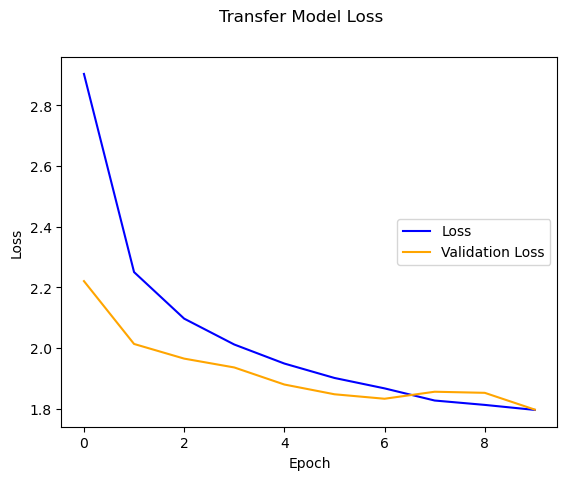

In [10]:
fig = plt.figure()
plt.plot(model_history.history['loss'], color='blue', label='Loss')
plt.plot(model_history.history['val_loss'], color='orange', label='Validation Loss')
plt.legend(loc='center right')
plt.suptitle('Transfer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

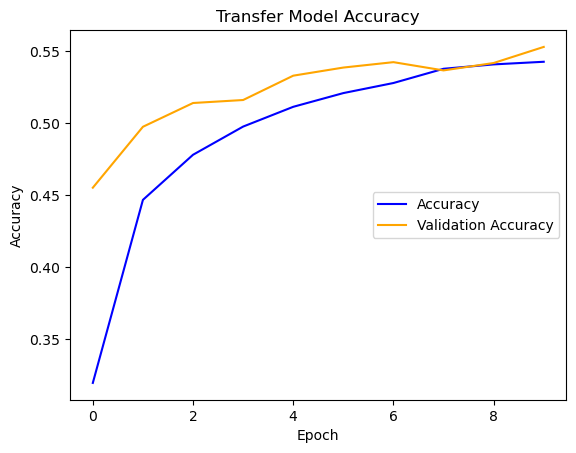

In [11]:
fig = plt.figure()
plt.plot(model_history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Transfer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [12]:
from keras.metrics import CategoricalAccuracy

accuracy = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y = tf.one_hot(y, num_classes)
    y_pred = model.predict(X)
    accuracy.update_state(y, y_pred)
    
print(f'Accuracy: {accuracy.result().numpy()}')

8/8 [==============================] - 1s 163ms/step
Accuracy: 0.5496795177459717


In [14]:
from keras.models import load_model

model.save(os.path.join('models', 'food_class_model.keras'))

In [16]:
# continue training with smaller learning rate
model_1 = load_model(os.path.join('models', 'food_class_model.keras'))

optimizer1 = SGD(learning_rate=0.001, momentum=0.9)
model_1.compile(optimizer=optimizer1, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 101)               103525    
                                                        

In [17]:
model_history1 = model_1.fit(
    train,
    epochs=10,
    validation_data=val,
    callbacks=tensorboard_callback,
    verbose=1
)

Epoch 1/10
316/316 [==============================] - 607s 2s/step - loss: 1.6225 - accuracy: 0.5853 - val_loss: 1.6860 - val_accuracy: 0.5744
Epoch 2/10
316/316 [==============================] - 628s 2s/step - loss: 1.5954 - accuracy: 0.5917 - val_loss: 1.7022 - val_accuracy: 0.5709
Epoch 3/10
316/316 [==============================] - 622s 2s/step - loss: 1.5909 - accuracy: 0.5918 - val_loss: 1.6666 - val_accuracy: 0.5746
Epoch 4/10
316/316 [==============================] - 618s 2s/step - loss: 1.5873 - accuracy: 0.5939 - val_loss: 1.6772 - val_accuracy: 0.5754
Epoch 5/10
316/316 [==============================] - 620s 2s/step - loss: 1.5858 - accuracy: 0.5931 - val_loss: 1.6811 - val_accuracy: 0.5742
Epoch 6/10
316/316 [==============================] - 618s 2s/step - loss: 1.5797 - accuracy: 0.5948 - val_loss: 1.6861 - val_accuracy: 0.5729
Epoch 7/10
316/316 [==============================] - 590s 2s/step - loss: 1.5757 - accuracy: 0.5964 - val_loss: 1.6799 - val_accuracy: 0.5722

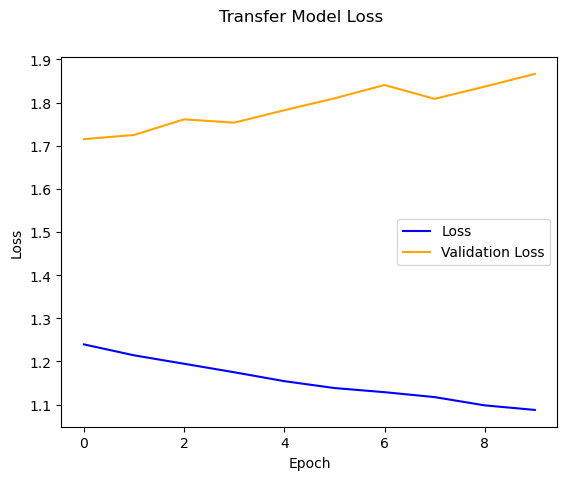

In [21]:
fig = plt.figure()
plt.plot(model_history1.history['loss'], color='blue', label='Loss')
plt.plot(model_history1.history['val_loss'], color='orange', label='Validation Loss')
plt.legend(loc='center right')
plt.suptitle('Transfer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

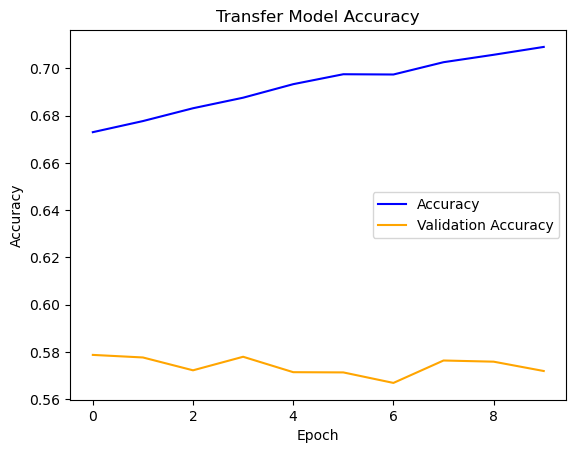

In [22]:
fig = plt.figure()
plt.plot(model_history1.history['accuracy'], color='blue', label='Accuracy')
plt.plot(model_history1.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Transfer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [23]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y = tf.one_hot(y, num_classes)
    y_pred = model_1.predict(X)
    accuracy.update_state(y, y_pred)
    
print(f'Accuracy: {accuracy.result().numpy()}')

8/8 [==============================] - 1s 157ms/step
Accuracy: 0.5852864384651184


In [13]:
model.save(os.path.join('models', 'food_class_model.keras'))